In [38]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import math
from sklearn.preprocessing import QuantileTransformer

In [2]:
# df_cem = pd.read_excel('data/CEM/Tabelas_MCidades.xls')

In [3]:
# df_cem

In [4]:
# Abrindo os dados espacializados para remover os setores Rurais

In [5]:
gdf_setores = gpd.read_file('data/censo_2000/br_set_cens_2000_4326.zip')

In [6]:
gdf_setores.to_crs(epsg='5880', inplace=True)

In [7]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [8]:
gdf_setores.shape

(128012, 9)

In [9]:
dimensoes = [
    # 'situacao_setor',#
    # 'tipo_setor',#
    'numero_de_domicilios',#
    'numero_moradores',#
    'porcentagem_domicilios_tipo_comodo', #
    'porcentagem_domicilios_sem_coleta_de_lixo', #
    'porcentagem_domicilios_sem_ligacao_rede_de_agua', #
    'porcentagem_domicilios_sem_banheiros', #
    'porcentagem_domicilios_sem_esgoto_ou_fossa', #
    'porcentagem_domicilios_cedidos_outra_forma', #
    'numero_de_banheiros_por_habitante', #
    'porcentagem_responsaveis_nao_alfabetizado', #
    'porcentagem_responsaveis_nao_alfabetizado_com_menos_de_30_anos', #
    'porcentagem_de_responsaveis_com_menos_30_anos', #
    'porcentagem_responsaveis_renda_ate_3_salarios', #
    'porcentagem_responsaveis_menos_8_anos_de_estudo', #
    'anos_medios_estudo_responsavel', #
    'renda_media_responsavel', #
    'numero_de_domicilios_improvisados', #
    'numero_medio_pessoas', #
]

In [10]:
df = pd.read_csv('resultados/modelo-2000.csv.zip')
df.fillna(0, inplace=True)
# rmsp = (df.rm == 20)


In [11]:
## join com dados espaciais

In [12]:
# df.numero_moradores.median()

In [13]:
df.shape

(215811, 29)

In [14]:
# Exclui setores com menos de 50 domicílios
df = df[df.numero_de_domicilios > 50]

In [15]:
df.shape

(200834, 29)

In [16]:
## Join na base geografica com a base de setores
# gdf_br_joined = gdf_br.set_index('Cod_setor').join(df.set_index('Cod_setor'), how='left', lsuffix='_df')
gdf_setores.loc[:, 'Cod_setor'] = gdf_setores.CD_GEOCODI.astype('int')
df = df.set_index('Cod_setor').join(gdf_setores.set_index('Cod_setor').area.rename('area_setor'))#.join(df.set_index('Cod_setor'), how='left', lsuffix='_df')

In [17]:
df.area_setor.isna().value_counts()

area_setor
False    124214
True      76620
Name: count, dtype: int64

In [18]:
df = df[~df.area_setor.isna()]

In [19]:

## exlcuir setores com densidade demográfica menor que algo a ser definido
df.loc[:, 'densidade_demografica'] = df.numero_moradores / (df.area_setor / 10000)

In [20]:
# REmovendo densidade demográgica menor que __ hab. por Ha.
condicao_de_densidade = (df.densidade_demografica > 8.) & (df.densidade_demografica < 1000000)
# df.loc[condicao_de_densidade, 'densidade_demografica'].describe()
df.loc[condicao_de_densidade, 'densidade_demografica'].shape
df = df.loc[condicao_de_densidade]

In [21]:
df.numero_moradores.describe()

count   116054.00
mean       901.35
std        373.74
min         86.00
25%        652.00
50%        858.00
75%       1096.00
max       7834.00
Name: numero_moradores, dtype: float64

In [22]:
df

,cod_grande_regiao,uf,nome_UF,rm,nome_rm,meso_regiao,cod_municipio,nome_municipio,situacao_setor,tipo_setor,...,porcentagem_responsaveis_nao_alfabetizado_com_menos_de_30_anos,porcentagem_de_responsaveis_com_menos_30_anos,porcentagem_responsaveis_renda_ate_3_salarios,porcentagem_responsaveis_menos_8_anos_de_estudo,anos_medios_estudo_responsavel,renda_media_responsavel,numero_de_domicilios_improvisados,numero_medio_pessoas,area_setor,densidade_demografica
Cod_setor,,,,,,,,,,,,,,,,,,,,,
120020305000001,1.00,12,AC,0,Não pertence,1201,1200203,Cruzeiro do Sul,1,0,...,0.15,0.17,0.56,0.32,1155.00,624.38,0,4.01,217696.54,48.09
120020305000002,1.00,12,AC,0,Não pertence,1201,1200203,Cruzeiro do Sul,1,0,...,0.18,0.19,0.54,0.39,1056.00,617.33,0,4.45,212881.41,52.09
120020305000003,1.00,12,AC,0,Não pertence,1201,1200203,Cruzeiro do Sul,1,0,...,0.16,0.17,0.63,0.50,931.00,557.25,0,4.63,254933.03,49.07
120020305000004,1.00,12,AC,0,Não pertence,1201,1200203,Cruzeiro do Sul,1,0,...,0.19,0.20,0.55,0.47,779.00,590.31,0,4.71,276221.34,45.00
120020305000005,1.00,12,AC,0,Não pertence,1201,1200203,Cruzeiro do Sul,1,0,...,0.20,0.23,0.76,0.40,893.00,334.32,0,4.63,219722.94,66.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172100005000111,1.00,17,TO,0,Não pertence,1702,1721000,Palmas,1,0,...,0.29,0.29,0.49,0.40,1171.00,557.54,1,3.77,199682.86,45.17
172100005000112,1.00,17,TO,0,Não pertence,1702,1721000,Palmas,1,0,...,0.29,0.29,0.53,0.44,1365.00,769.14,0,3.20,175248.74,45.48
172100005000113,1.00,17,TO,0,Não pertence,1702,1721000,Palmas,1,0,...,0.29,0.29,0.52,0.46,1114.00,1004.47,20,4.14,171675.47,56.62


In [23]:
subnormal = (df.tipo_setor == 1)
df.loc[:, 'subnormal'] = 0
df.loc[subnormal, 'subnormal'] = 1
df.loc[:, 'processado'] = False

In [24]:
r_subnormal = df.loc[(subnormal), ['rm', 'subnormal']].groupby('rm').count().reset_index()
cidades_fora_rms = r_subnormal[(r_subnormal.subnormal < 20) | (r_subnormal.rm == 0.)].rm.to_list()
rms = r_subnormal[(r_subnormal.subnormal >= 20) & (r_subnormal.rm != 0.)].rm.to_list()

In [25]:
rms

[1, 2, 3, 5, 6, 7, 8, 10, 13, 14, 15, 16, 17, 26, 28]

In [26]:
df.loc[:, ['rm', 'nome_rm']].groupby('rm').first()

,nome_rm
rm,
0,Não pertence
1,Belém
2,Grande São Luís
3,Fortaleza
4,Natal
5,Recife
6,Maceió
7,Salvador
8,Belo Horizonte


In [57]:
def processa_modelos(filter, rm=None, uf=None):

    registro = {}

    # filter = (df.rm == rm)
    df_rm = df.loc[(filter)]
    df.loc[(filter), 'processado'] = True
    # print(df.loc[(filter)].shape)

    # print(df_rm.nome_rm.unique()[0])
    if rm:
        registro['nome_rm_ou_UF'] = df_rm.nome_rm.unique()[0]
    
    if uf:
        registro['nome_rm_ou_UF'] = uf
    # print(df_rm.subnormal.value_counts())

    registro['quantidade_de_municipios_processados'] = df_rm.cod_municipio.unique().shape[0]

    setores_normais = df_rm.loc[filter & (df_rm.loc[filter].subnormal == 0)].shape[0]
    registro['quantidade_original_de_setores_normais'] = setores_normais
    
    setores_subnormais = df_rm.loc[filter & (df_rm.loc[filter].subnormal == 1)].shape[0]
    registro['quantidade_original_de_setores_subnormais'] = setores_subnormais
    # print(setores_normais, setores_subnormais)
    

    samples = min(setores_normais, math.floor(setores_subnormais * 1.7))
    # samples = 1

    # prepara amostras e lições
    x = df_rm.loc[(filter) & (subnormal)]
    x_ = df_rm.loc[(filter) & (~subnormal)]#.sample(n=samples, random_state=13)
    X = pd.concat([x, x_]).loc[(filter), dimensoes]
    transformer = Normalizer().fit(X)
    
    # X = transformer.transform(X)

    y = pd.concat([x, x_]).loc[(filter), 'subnormal']
    # X = df_rm.loc[(filter), dimensoes]
    # y = df_rm.loc[(filter), 'subnormal']


# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
    # Processa os modelos, LDA
    # print(y.value_counts())
    # clf = LinearDiscriminantAnalysis(solver='lsqr')
    clf = QuadraticDiscriminantAnalysis()
    clf.fit(X, y)
    print(df_rm.nome_rm.unique()[0])
    print(X.shape)
    # print(clf.coef_)
    # print(np.unique(clf.predict(X), return_counts=True))
    # predicao = clf.predict(transformer.transform(df_rm.loc[(filter), dimensoes]))
    predicao = clf.predict(df_rm.loc[(filter), dimensoes])
    try: 
        atribuidos_como_subnormais = np.unique(predicao, return_counts=True)[1][1]
    except:
        atribuidos_como_subnormais = 0
    registro['atribuidos_como_subnormais_LDA'] = atribuidos_como_subnormais
    # print(clf.score(X, y))
    registro['proporcao_atribuido_original_LDA'] = atribuidos_como_subnormais / setores_subnormais
    registro['score_LDA'] = clf.score(X, y)
    df.loc[(filter), 'subnormal_LDA'] = predicao

    # Processa model RandonForest
    # clf = RandomForestClassifier(max_depth=10, random_state=0)
    clf = GaussianNB()
    clf.fit(X, y)
    # print(np.unique(clf.predict(X), return_counts=True))
    # predicao = clf.predict(transformer.transform(df_rm.loc[(filter), dimensoes]))
    predicao = clf.predict(df_rm.loc[(filter), dimensoes])
    try:
        atribuidos_como_subnormais = np.unique(predicao, return_counts=True)[1][1]
    except:
        atribuidos_como_subnormais = 0    
    registro['atribuidos_como_subnormais_RandomForest'] = atribuidos_como_subnormais
    # print(clf.score(X, y))
    registro['proporcao_atribuido_original_RandomForest'] = atribuidos_como_subnormais / setores_subnormais
    registro['score_RandomForest'] = clf.score(X, y)
    df.loc[(filter), 'subnormal_RandomForest'] = predicao


    # Processa modelo SVC
    clf = SVC(C=1, random_state=42)
    clf.fit(Normalizer().fit_transform(X), y)
    # print(np.unique(clf.predict(X), return_counts=True))
    predicao = clf.predict(Normalizer().fit_transform(df_rm.loc[(filter), dimensoes]))
    try:
        atribuidos_como_subnormais = np.unique(clf.predict(Normalizer().fit_transform(df_rm.loc[(filter), dimensoes])), return_counts=True)[1][1]
    except:
        atribuidos_como_subnormais = 0    
    registro['atribuidos_como_subnormais_SVC'] = atribuidos_como_subnormais
    # print(clf.score(X, y))
    registro['proporcao_atribuido_original_SVC'] = atribuidos_como_subnormais / setores_subnormais
    registro['score_SVC'] = clf.score(Normalizer().fit_transform(X), y)
    df.loc[(filter), 'subnormal_SVC'] = predicao

    # Salva as predicoes em atributos
    return registro

In [58]:
# Processa cada um dos municípios da sua Região MEtropolitana
result = [] 

for rm in rms:

    rm_filter = (df.rm == rm)
    registro = processa_modelos(rm_filter, rm=rm)
    # Salva as predicoes em atributos
    result.append(registro)

Belém
(1530, 18)
Grande São Luís
(862, 18)
Fortaleza
(2565, 18)
Recife
(2495, 18)
Maceió
(697, 18)
Salvador
(2799, 18)
Belo Horizonte
(4130, 18)
Vale do Aço
(379, 18)
Rio de Janeiro
(13780, 18)
São Paulo
(20291, 18)
Baixada Santista
(1734, 18)
Campinas
(2603, 18)
Curitiba
(2678, 18)
Porto Alegre
(4431, 18)
Região Integrada de Desenvolvimento do Distrito Federal e Entorno
(2752, 18)


In [52]:
# clf.coef_

In [53]:
# df.loc[df.subnormal == 1, dimensoes].describe()

In [54]:
# df.loc[df.subnormal == 0, dimensoes].describe()

<Axes: ylabel='Density'>

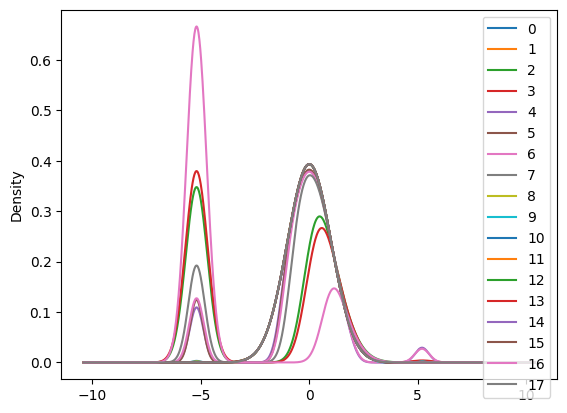

In [47]:
qt = QuantileTransformer(output_distribution='normal')
seila = qt.fit_transform(df.loc[subnormal, dimensoes])
pd.DataFrame(seila).plot.kde()

# df.loc[subnormal].numero_medio_pessoas.plot.kde()
# df.loc[~subnormal].numero_medio_pessoas.plot.kde()

# df.loc[subnormal].anos_medios_estudo_responsavel.plot.kde()
# df.loc[~subnormal].anos_medios_estudo_responsavel.plot.kde()

# df.loc[subnormal].porcentagem_responsaveis_menos_8_anos_de_estudo.plot.kde()
# df.loc[~subnormal].porcentagem_responsaveis_menos_8_anos_de_estudo.plot.kde()

# df.loc[subnormal].porcentagem_responsaveis_nao_alfabetizado_com_menos_de_30_anos.plot.kde()
# df.loc[~subnormal].porcentagem_responsaveis_nao_alfabetizado_com_menos_de_30_anos.plot.kde()

# df.loc[subnormal].porcentagem_domicilios_sem_coleta_de_lixo.plot.kde()
# df.loc[~subnormal].porcentagem_domicilios_sem_coleta_de_lixo.plot.kde()

# df.loc[subnormal].porcentagem_domicilios_sem_coleta_de_lixo.plot.kde()
# df.loc[~subnormal].porcentagem_domicilios_sem_coleta_de_lixo.plot.kde()


In [33]:
# df.loc[subnormal].anos_medios_estudo_responsavel.plot.kde()
# df.loc[~subnormal].anos_medios_estudo_responsavel.plot.kde()

In [56]:
# df.rm.isin([13, 14, 15, 16]) &
df.loc[(df.subnormal == 1) | (df.subnormal_RandomForest == 1), ['rm', 'nome_rm', 'numero_de_domicilios', 'numero_moradores']].groupby('rm').agg({
    'nome_rm': 'first',
    'rm': 'count',
    'numero_de_domicilios': 'sum',
    'numero_moradores': 'sum'
})

,nome_rm,rm,numero_de_domicilios,numero_moradores
rm,,,,
0,Não pertence,931,187970.00,761703.00
1,Belém,873,227380.00,999840.00
2,Grande São Luís,312,84059.00,369693.00
3,Fortaleza,1385,341535.00,1440488.00
4,Natal,7,1283.00,5551.00
5,Recife,1023,334583.00,1333164.00
6,Maceió,106,21867.00,90010.00
7,Salvador,1047,290167.00,1140481.00
8,Belo Horizonte,1481,371448.00,1472453.00


In [40]:

dimensoes.append('subnormal')

In [44]:
dimensoes.append('rm')
# df.columns

In [46]:
df.loc[df.rm != 0, dimensoes].to_csv('resultados/conferencia-lab-geo.csv.zip')

In [77]:
# Resultados Parciais espacializados para as RMS ([13, 14, 15, 16])
gdf_setores = gpd.read_file('data/censo_2000/br_set_cens_2000_4326.zip')

In [14]:
# df.dtypes


In [15]:
gdf_setores.loc[:, 'Cod_setor'] = gdf_setores.CD_GEOCODI.astype('int')

In [16]:
gdf_setores_joined = gdf_setores.set_index('Cod_setor').join(df.set_index('Cod_setor'), how='left', lsuffix='_df')

In [17]:
gdf_setores_joined.loc[:, 'legenda'] = 'Setores Comuns'
gdf_setores_joined.loc[gdf_setores_joined.subnormal_LDA.isna(), 'legenda'] = 'Sem Informação'

In [18]:
subnormal = (gdf_setores_joined.tipo_setor == 1)

In [19]:
gdf_setores_joined.loc[subnormal, 'legenda'] = 'Subnormais'

In [20]:
precarios = (gdf_setores_joined.subnormal_LDA == 1.0)

In [21]:
gdf_setores_joined.loc[(precarios & ~subnormal), 'legenda'] = 'Precários'

In [22]:
# gdf_setores

In [23]:
gdf_setores_joined.legenda.value_counts()

legenda
Setores Comuns    57361
Sem Informação    57068
Subnormais         7783
Precários          5800
Name: count, dtype: int64

In [24]:
# gdf_setores_joined.loc[~gdf_setores_joined.subnormal_LDA.isna(), ['geometry', 'subnormal_LDA', 'legenda']].to_file('resultados/test_rms_samples_X_2.gpkg', driver='GPKG')

In [ ]:
# result

In [ ]:
df.subnormal_LDA.value_counts()

In [ ]:
df.subnormal_RandomForest.value_counts()

In [ ]:
df.columns

In [ ]:
r_ufs = df[df.rm.isin(cidades_fora_rms)].loc[(subnormal), ['nome_UF', 'subnormal']].groupby('nome_UF').count().reset_index()

In [ ]:
r_ufs

In [ ]:
df_setores = df[df.rm.isin(cidades_fora_rms)].loc[:, ['nome_UF', 'subnormal', 'Cod_setor']].groupby('nome_UF').agg({'subnormal': 'sum', 'Cod_setor':'count'})

In [ ]:
df_setores[df_setores.subnormal < 20]

In [ ]:
df_setores[df_setores.subnormal < 20].sum()

In [ ]:
cidades_fora_rms

In [ ]:
r_ufs[r_ufs.subnormal >= 20]

In [ ]:
r_ufs[r_ufs.subnormal < 20]

In [ ]:
# df[(df.rm.isin(cidades_fora_rms))]

In [ ]:
# Processa cada uma das UFs
df_uf = df[df.rm.isin(cidades_fora_rms)]
ufs = r_ufs[r_ufs.subnormal >= 20].nome_UF.to_list()

for uf in ufs:

    uf_filter = (df.nome_UF == uf) & (df.rm.isin(cidades_fora_rms))
    print(uf)

    registro = processa_modelos(uf_filter, uf=uf)
    # Salva as predicoes em atributos
    result.append(registro)


In [ ]:
gr_filter = (df.cod_grande_regiao == 4.) & (df.subnormal_LDA.isna())

In [ ]:
## TODO
## Processar as cidades restantes por MacroRegião 
## Região 4 (Sul) não possui licoes suficientes de municípios com setores subnormais
for gr in [1., 2., 3., 5.]:
    gr_filter = (df.cod_grande_regiao == gr) & (~df.processado)
    print(gr)

    if len(df[gr_filter]) > 0:
        registro = processa_modelos(gr_filter, uf=f'Macro Região {str(gr)}')
        # Salva as predicoes em atributos
        result.append(registro)

In [ ]:
df[df.cod_grande_regiao == 4.]

In [ ]:
pd.DataFrame(result).to_excel('resultados/geral_por_RM_UF.xlsx')

In [ ]:
pd.DataFrame(result).quantidade_de_municipios_processados.sum()

In [ ]:
df.subnormal_LDA.value_counts()

In [ ]:
df.subnormal_RandomForest.value_counts()
# df.columns

In [ ]:
df.subnormal.value_counts()

In [ ]:
df.to_csv('resultados/modelo_preditivo.csv.zip', compression='zip')

In [ ]:
df[df.subnormal_LDA.isna()]

In [ ]:
df

In [ ]:
df.processado.value_counts()